In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from collections import Counter
import cryptoaml.datareader as cdr

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from skmultiflow.meta import LearnNSE
from skmultiflow.meta import LeverageBagging
from skmultiflow.trees import HoeffdingTree
from sklearn.tree import DecisionTreeClassifier
from skmultiflow.meta import AdaptiveRandomForest
from cryptoaml.models import AdaptiveXGBoostClassifier
from cryptoaml.models import AdaptiveStackedBoostClassifier

from sklearn.exceptions import UndefinedMetricWarning

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NeighbourhoodCleaningRule

from cryptoaml.metrics import (
    results_table, 
    plot_metric_dist,
    plot_feature_imp,
    print_model_params, 
    plot_result_matrices,
    display_metrics_stats,
    elliptic_time_indexed_results
)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

/home/delinvas/anaconda3/envs/btc-classifier/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [2]:
def evaluate_batch_incremental(model, data, t_eval=35):
    
    results = {}
    results_time = []
    true_test = []
    predictions_test = []
    
    for ts in np.arange(data["ts"].min(), data["ts"].max()):
        
        # get training data for the current timestep 
        train_set = data[data["ts"] == ts]
        train_set_X = train_set.iloc[:,:-1]
        train_set_y = train_set["class"]      

        # partially fit model 
        model.partial_fit(train_set_X.values, train_set_y.values)    

        # get test data for the current timestep + 1 
        test_set = data[data["ts"] == ts + 1]
        test_set_X = test_set.iloc[:,:-1].values
        test_set_y = test_set["class"].values
    
        # predict test data for the current timestep + 1
        y_pred = model.predict(test_set_X)
        evaluation_f1 = f1_score(test_set_y, y_pred, average='binary', labels=np.unique(y_pred))
        evaluation_recall = recall_score(test_set_y, y_pred, average='binary', labels=np.unique(y_pred))
        evaluation_precision = precision_score(test_set_y, y_pred, average='binary', labels=np.unique(y_pred))
        evaluation_accuracy = accuracy_score(test_set_y, y_pred, normalize=True)
        
        # take note of predictions after timestep 34 (evaluation set)
        if ts+1 >= t_eval:
            true_test.append(test_set_y)
            predictions_test.append(y_pred)
            label_count = test_set["class"].value_counts()
            results_time.append({"timestep": ts + 1, 
                                 "score":evaluation_f1, 
                                 "total_pos_label": label_count.tolist()[1]}) 

            
    test_results = {}
    f1_score_test = f1_score(np.concatenate(true_test, axis=0), 
                        np.concatenate(predictions_test, axis=0), 
                        average='binary')
    recall_score_test = recall_score(np.concatenate(true_test, axis=0),   
                                np.concatenate(predictions_test, axis=0), 
                                average='binary')
    precision_score_test = precision_score(np.concatenate(true_test, axis=0),   
                                      np.concatenate(predictions_test, axis=0), 
                                      average='binary')
    accuracy_score_test = accuracy_score(np.concatenate(true_test, axis=0),   
                                    np.concatenate(predictions_test, axis=0), 
                                    normalize=True)
    confusion_matrix_test = confusion_matrix(np.concatenate(true_test, axis=0), 
                                             np.concatenate(predictions_test, axis=0))
    
    test_results["f1"] = round(f1_score_test, 3)   
    test_results["recall"] = round(recall_score_test, 3)   
    test_results["precision"] = round(precision_score_test, 3)   
    test_results["accuracy"] = round(accuracy_score_test, 3)   
    test_results["confusion_matrix"] = confusion_matrix_test  
    
    results["test_results"] = test_results
    results["time_metrics"] = pd.DataFrame(results_time)   

    return results

In [3]:
def evaluate(feature_set, n_eval):
    elliptic = cdr.get_data("elliptic")
    data_eval = elliptic.train_test_split(train_size=0.7, 
                                     feat_set=feature_set, 
                                     inc_meta=False,
                                     inc_unknown=False)

    train_data = data_eval.train_X
    train_data["class"] = data_eval.train_y
    test_data = data_eval.test_X
    test_data["class"] = data_eval.test_y 
    data_eval = train_data.append(test_data, ignore_index=True)
    
    f_set = "elliptic"+"_"+feature_set
    experiment_3_results = {}
    experiment_3_results["ARF"] = {}
    experiment_3_results["AXGBr"] = {}
    experiment_3_results["AXGBp"] = {}
    experiment_3_results["ASXGB"] = {}
    experiment_3_results["ARF"][f_set] = {}
    experiment_3_results["AXGBr"][f_set] = {}
    experiment_3_results["AXGBp"][f_set] = {}
    experiment_3_results["ASXGB"][f_set] = {}

    # 2. Adapative Random Forest
    print("Evaluating ARF")
    arf = AdaptiveRandomForest(performance_metric="kappa")
    experiment_3_results["ARF"][f_set] = evaluate_batch_incremental(arf, data_eval, n_eval)
    
    # 2. Adapative Extreme Gradient Boosting with Replacement
    # 3. Adapative Extreme Gradient Boosting with Push
    # Adaptive XGBoost classifier parameters
    n_estimators = 30       # Number of members in the ensemble
    learning_rate = 0.3     # Learning rate or eta
    max_depth = 6           # Max depth for each tree in the ensemble
    max_window_size = 1000  # Max window size
    min_window_size = 1     # set to activate the dynamic window strategy
    detect_drift = False    # Enable/disable drift detection

    print("Evaluating AXGBr")
    AXGBr = AdaptiveXGBoostClassifier(update_strategy='replace',
                                      n_estimators=n_estimators,
                                      learning_rate=learning_rate,
                                      max_depth=max_depth,
                                      max_window_size=max_window_size,
                                      min_window_size=min_window_size,
                                      detect_drift=detect_drift)
    experiment_3_results["AXGBr"][f_set] = evaluate_batch_incremental(AXGBr, data_eval, n_eval)

    print("Evaluating AXGBp")
    AXGBp = AdaptiveXGBoostClassifier(update_strategy='push',
                                      n_estimators=n_estimators,
                                      learning_rate=learning_rate,
                                      max_depth=max_depth,
                                      max_window_size=max_window_size,
                                      min_window_size=min_window_size,
                                      detect_drift=detect_drift)
    experiment_3_results["AXGBp"][f_set] = evaluate_batch_incremental(AXGBp, data_eval, n_eval)

    # 4. Proposed Method
    print("Evaluating ASXGB")
    ASXGB = AdaptiveStackedBoostClassifier()
    experiment_3_results["ASXGB"][f_set] = evaluate_batch_incremental(ASXGB, data_eval, n_eval)
    
    elliptic_time_indexed_results(experiment_3_results)
    print(experiment_3_results)

Evaluating ARF
Evaluating AXGBr
Evaluating AXGBp
Evaluating ASXGB


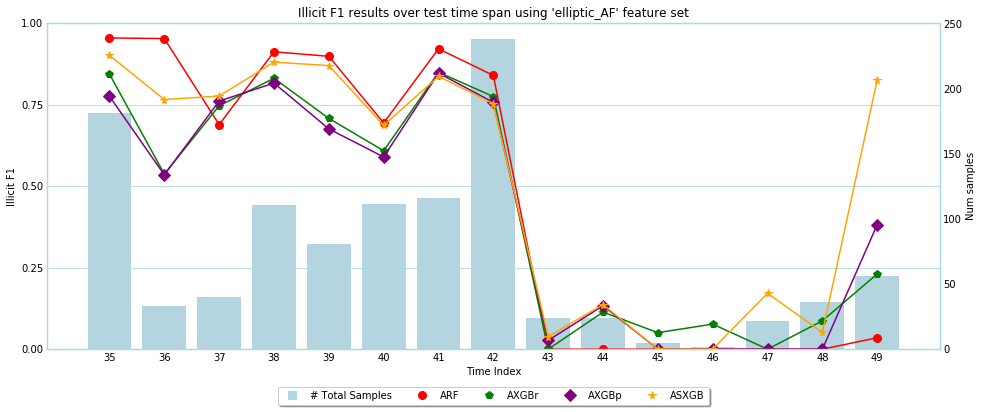

{'ARF': {'elliptic_AF': {'test_results': {'f1': 0.789, 'recall': 0.657, 'precision': 0.988, 'accuracy': 0.977, 'confusion_matrix': array([[15578,     9],
       [  371,   712]])}, 'time_metrics':     timestep     score  total_pos_label
0         35  0.954286              182
1         36  0.952381               33
2         37  0.688525               40
3         38  0.911765              111
4         39  0.897959               81
5         40  0.693642              112
6         41  0.920930              116
7         42  0.839329              239
8         43  0.000000               24
9         44  0.000000               24
10        45  0.000000                5
11        46  0.000000                2
12        47  0.000000               22
13        48  0.000000               36
14        49  0.035088               56}}, 'AXGBr': {'elliptic_AF': {'test_results': {'f1': 0.648, 'recall': 0.719, 'precision': 0.59, 'accuracy': 0.949, 'confusion_matrix': array([[15045,   542],
       

In [4]:
evaluate("AF", 35)

Evaluating ARF
Evaluating AXGBr
Evaluating AXGBp
Evaluating ASXGB


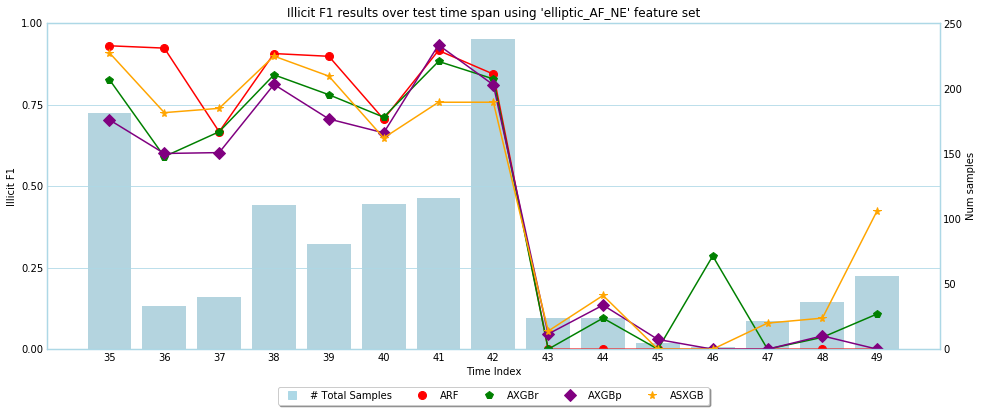

{'ARF': {'elliptic_AF_NE': {'test_results': {'f1': 0.783, 'recall': 0.648, 'precision': 0.987, 'accuracy': 0.977, 'confusion_matrix': array([[15578,     9],
       [  381,   702]])}, 'time_metrics':     timestep     score  total_pos_label
0         35  0.930233              182
1         36  0.923077               33
2         37  0.666667               40
3         38  0.906404              111
4         39  0.897959               81
5         40  0.705202              112
6         41  0.915888              116
7         42  0.843373              239
8         43  0.000000               24
9         44  0.000000               24
10        45  0.000000                5
11        46  0.000000                2
12        47  0.000000               22
13        48  0.000000               36
14        49  0.000000               56}}, 'AXGBr': {'elliptic_AF_NE': {'test_results': {'f1': 0.704, 'recall': 0.694, 'precision': 0.713, 'accuracy': 0.962, 'confusion_matrix': array([[15285,   302],


In [5]:
evaluate("AF_NE", 35)

Evaluating ARF
Evaluating AXGBr
Evaluating AXGBp
Evaluating ASXGB


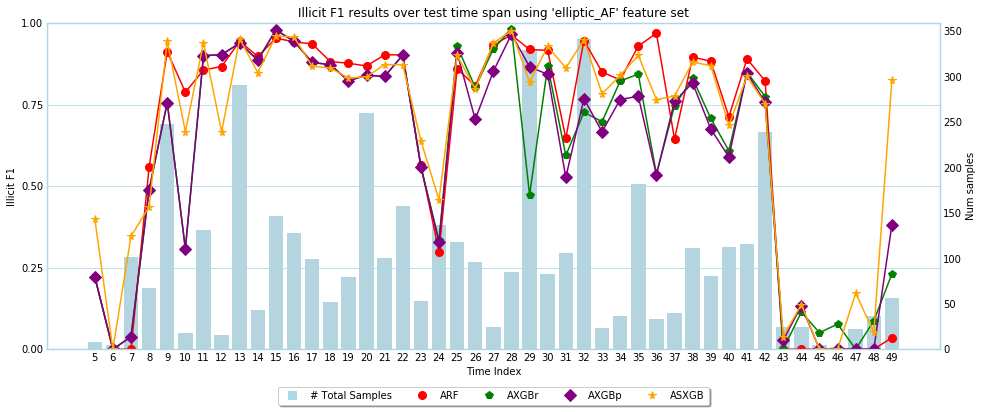

{'ARF': {'elliptic_AF': {'test_results': {'f1': 0.84, 'recall': 0.732, 'precision': 0.986, 'accuracy': 0.969, 'confusion_matrix': array([[36065,    47],
       [ 1199,  3270]])}, 'time_metrics':     timestep     score  total_pos_label
0          5  0.222222                8
1          6  0.000000                5
2          7  0.000000              102
3          8  0.559140               67
4          9  0.912206              248
5         10  0.787879               18
6         11  0.855895              131
7         12  0.866667               16
8         13  0.943942              291
9         14  0.897436               43
10        15  0.953737              147
11        16  0.942149              128
12        17  0.936170               99
13        18  0.881720               52
14        19  0.876712               80
15        20  0.868251              260
16        21  0.902564              100
17        22  0.902357              158
18        23  0.564103               53
19   

In [6]:
evaluate("AF", 5)

Evaluating ARF
Evaluating AXGBr
Evaluating AXGBp
Evaluating ASXGB


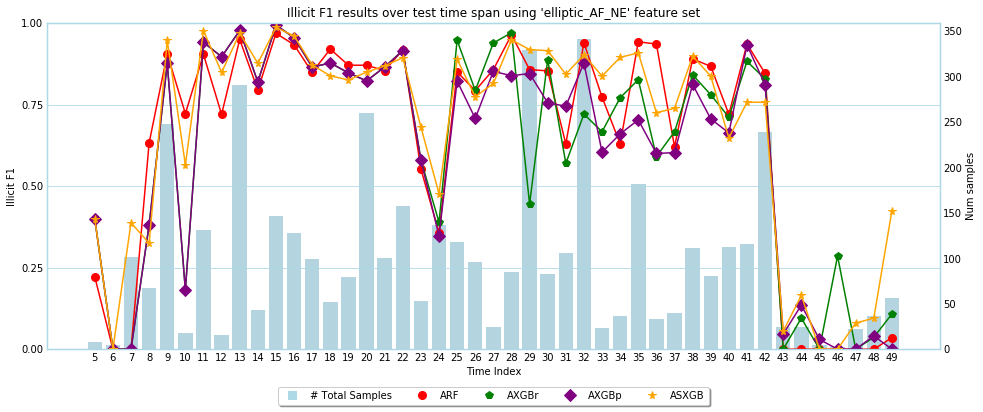

{'ARF': {'elliptic_AF_NE': {'test_results': {'f1': 0.832, 'recall': 0.724, 'precision': 0.979, 'accuracy': 0.968, 'confusion_matrix': array([[36042,    70],
       [ 1235,  3234]])}, 'time_metrics':     timestep     score  total_pos_label
0          5  0.222222                8
1          6  0.000000                5
2          7  0.000000              102
3          8  0.632653               67
4          9  0.905077              248
5         10  0.722222               18
6         11  0.903766              131
7         12  0.720000               16
8         13  0.949821              291
9         14  0.794521               43
10        15  0.968421              147
11        16  0.933333              128
12        17  0.848837               99
13        18  0.920000               52
14        19  0.870748               80
15        20  0.870488              260
16        21  0.854167              100
17        22  0.917492              158
18        23  0.552632               53
1

In [7]:
evaluate("AF_NE", 5)